<a href="https://colab.research.google.com/github/CharlesRMcCullough/PyTorch-Udemy/blob/main/PyTorchMultiClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path


## Multi-Class Classification


### Creating a toy multi-class dataset

In [2]:
# Set tthe hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42



In [3]:
X_blob, y_blob = make_blobs(n_samples=1000,
                          n_features=NUM_FEATURES,
                          centers=NUM_CLASSES,
                          cluster_std=1.5,
                          random_state=RANDOM_SEED)

In [4]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [5]:
# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                      y_blob,
                                                      test_size=0.2,
                                                      random_state=RANDOM_SEED)

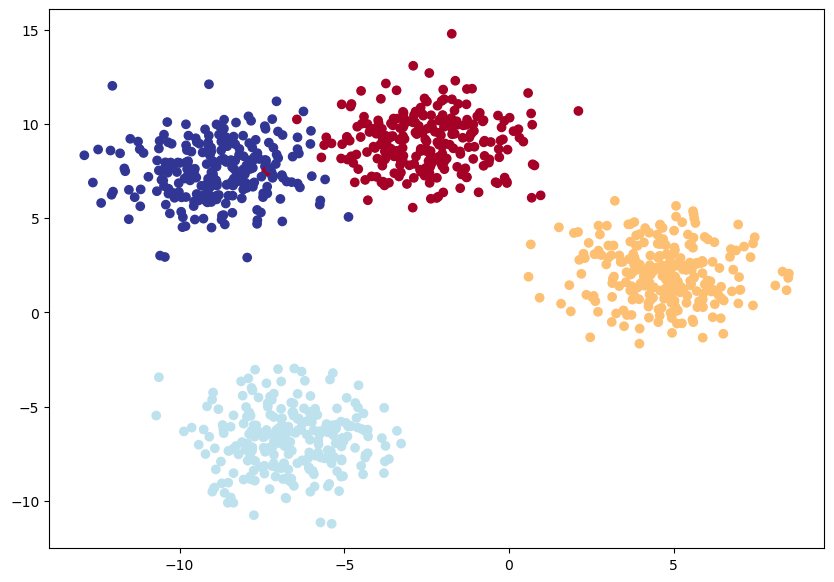

In [6]:
# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [7]:
# Create device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# Bild a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initialize multi-class classification model.
        Args:
          input_features (int): number of input features to the model
          output_features (int): number of output features of the model
          hidden_units (int): number of hidden units between layers, default 8

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [9]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [10]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [11]:
## Create loss function and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_4.parameters(), lr=0.01)

#### Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test out model, we need to convert out models outpus (logits) to prediction probabilities and the to prediction labels.

Logits (raw output of the model) -> Pred probs (used 'torch.softmax') ->
Pred labels

(take the argmax of the prediction probilities)

In [12]:
# Getting predicition probabilities for a multi-class PyTorch model

model_4(X_blob_train.to(device))[:5]

tensor([[ 0.3056,  0.2986, -0.3574, -0.7368],
        [ 0.1151,  0.3392, -0.7552, -0.3595],
        [ 0.2026, -0.1909, -0.4549, -0.3142],
        [ 0.1878, -0.2161, -0.3838, -0.2531],
        [ 0.1408,  0.1223, -0.6543, -0.2050]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [13]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [14]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[ 0.2916,  0.3695, -0.4170, -0.7613],
        [ 0.1977,  0.0888, -0.6540, -0.2506],
        [ 0.1860, -0.2194, -0.4469, -0.2620],
        [ 0.2641,  0.0662, -0.2782, -0.5180],
        [ 0.1399,  0.5531, -0.7364, -0.6316]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3422, 0.3699, 0.1685, 0.1194],
        [0.3376, 0.3027, 0.1440, 0.2156],
        [0.3525, 0.2350, 0.1872, 0.2252],
        [0.3497, 0.2870, 0.2033, 0.1600],
        [0.2950, 0.4459, 0.1228, 0.1364]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [15]:
# Convert out model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]


tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')

In [16]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

#### Creating a training and testing loop for a multi-class model

In [22]:
# Fit the multi-class model to the data

if device == "cuda":
  torch.cuda.manual_seed(42)
else:
  torch.manual_seed(42)

epochs = 1000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)





In [24]:
for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [19]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 1.9710,  7.3233, -2.4687, -6.8801],
        [-0.2521, -5.3336, -2.8305,  4.6909],
        [-4.3283, -1.1424,  5.3591, -1.1489],
        [-0.1123,  5.0196, -0.5632, -4.5570],
        [ 7.8815,  3.2477, -7.2223, -4.1307],
        [-0.3435, -6.2520, -3.2670,  5.5427],
        [-3.9746, -1.2291,  4.8979, -0.9309],
        [ 6.2550, -0.1053, -6.2190, -0.9787],
        [-5.0883, -1.1125,  6.3342, -1.4972],
        [ 6.8899,  1.0708, -6.5203, -2.1291]], device='cuda:0')

In [20]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


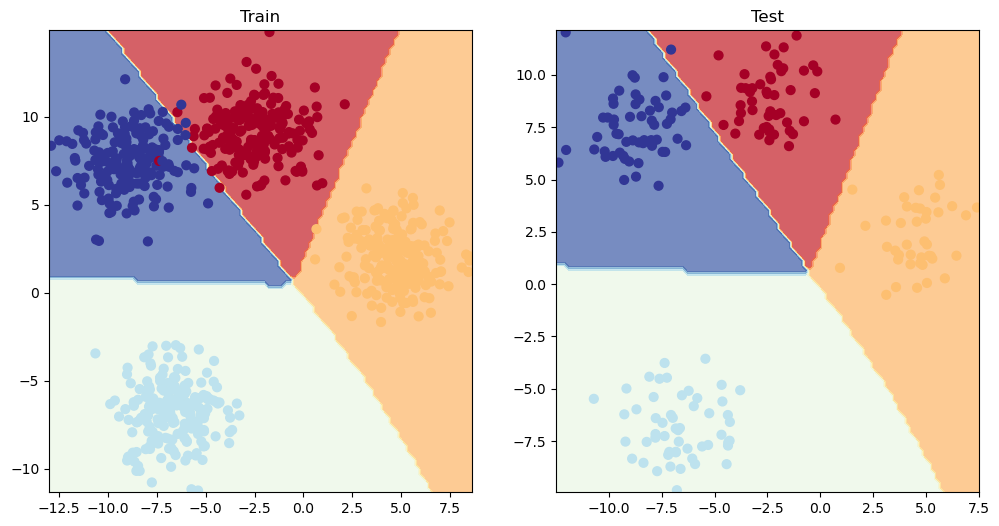

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)